# Copyright 2019 Daniel N. Wilke 
# [e-mail: nico.wilke@up.ac.za]
# [twitter: @daniwi79]

## Consider a bar that is clamped at $x=0$ at the right edge $x=1.0$.
## The area of the bar changes with $x$ and is given by $A(x) = 0.0002\;m^2$.
## The bar has a Young's modulus of $E=210$ GPa.
## Lets investigate the properties of the global stiffness matrix (before we constrained the bar)
## First we need to convert it to a numpy array!

In [2]:
import numpy as np
import sympy as sp
xi = sp.symbols('xi')

# Define the shape functions
N1 = -1/2*xi*(1-xi)
N2 = 1/2*xi*(1+xi)
N3 = (1-xi)*(1+xi)

# Isoparametric formulation - relate x and xi
x1 = 0;x2 = 1.0;x3 = 0.5
x = N1*x1 + N2*x2 + N3*x3

# Define the area in terms of x, which in turn is related to xi - here A(xi) since x(xi).
A = 0.0002 + 0.0001*x*0
print('A: {}'.format(A.simplify()))

E = 210E9
L = x2 - x1

# Setup a list of the shape functions N1, N2 and N3
N = [N1,N2,N3]

# Stiffness matrix
dxdxi = sp.derive_by_array(x,xi); print('dxdxi {}'.format(dxdxi))
dxidx = 1/dxdxi

B = dxidx*sp.derive_by_array(N,xi); print('B {}'.format(B))
Bmat = sp.Matrix(B).transpose() # sp.Matrix converts a 3 vector (3) into a column vector (3x1) by default!s
BTEB = Bmat.transpose()*E*Bmat; print('BT*E*B whichs is a 3x1 vector times a 1x3 vector {}'.format(BTEB))

integrandStiffnessMatrix = BTEB*A*dxdxi
# 2-point Gauss Quadrature Integration
StiffnessMatrix = 1.0*integrandStiffnessMatrix.subs({xi:-1/3**0.5}) + 1.0*integrandStiffnessMatrix.subs({xi:1/3**0.5})
sp.pretty_print(StiffnessMatrix)

A: 0.000200000000000000
dxdxi 0.500000000000000
B [2.0*xi - 1.0, 2.0*xi + 1.0, -4.0*xi]
BT*E*B whichs is a 3x1 vector times a 1x3 vector Matrix([[(2.0*xi - 1.0)*(420000000000.0*xi - 210000000000.0), (2.0*xi + 1.0)*(420000000000.0*xi - 210000000000.0), -4.0*xi*(420000000000.0*xi - 210000000000.0)], [(2.0*xi - 1.0)*(420000000000.0*xi + 210000000000.0), (2.0*xi + 1.0)*(420000000000.0*xi + 210000000000.0), -4.0*xi*(420000000000.0*xi + 210000000000.0)], [-840000000000.0*xi*(2.0*xi - 1.0), -840000000000.0*xi*(2.0*xi + 1.0), 3360000000000.0*xi**2]])
⎡ 98000000.0    14000000.0   -112000000.0⎤
⎢                                        ⎥
⎢ 14000000.0    98000000.0   -112000000.0⎥
⎢                                        ⎥
⎣-112000000.0  -112000000.0  224000000.0 ⎦


## The way I computed the stiffness above its matrix type is:
### sympy.matrices.dense.MutableDenseMatrix
## although it is fully integrated to only contain numbers

In [3]:
type(StiffnessMatrix)

sympy.matrices.dense.MutableDenseMatrix

## We can convert it to a numpy array as follows:

In [4]:
StiffnessMatrixNPOBJECT = np.array(StiffnessMatrix)
StiffnessMatrixNPOBJECT

array([[98000000.0000000, 14000000.0000000, -112000000.000000],
       [14000000.0000000, 98000000.0000000, -112000000.000000],
       [-112000000.000000, -112000000.000000, 224000000.000000]],
      dtype=object)

## Note that the DTYPE of the array is OBJECT - some operations may fail for determinant calc:

In [5]:
np.linalg.det(StiffnessMatrixNPOBJECT)

TypeError: No loop matching the specified signature and casting
was found for ufunc det

## We need to convert this to an array of type float

In [6]:
StiffnessMatrixNPFLOAT = np.array(StiffnessMatrixNPOBJECT, dtype=float)
StiffnessMatrixNPFLOAT

array([[ 9.80e+07,  1.40e+07, -1.12e+08],
       [ 1.40e+07,  9.80e+07, -1.12e+08],
       [-1.12e+08, -1.12e+08,  2.24e+08]])

## Note now the determinant calculation works:

In [7]:
np.linalg.det(StiffnessMatrixNPFLOAT)

0.0

## *There is a current bug in scipy we cannot convert the StiffnessMatrix directly to StiffnessMatrixNPFLOAT*
## To convert a symbolic matrix to a numpy array of type float we have to do it in two steps:
## 1. Convert StiffnessMatrix to StiffnessMatrixNPOBJECT
## 2. Convert StiffnessMatrixNPOBJECT to StiffnessMatrixNPFLOAT
# at least until the bug is fixed!

## Stiffness matrix is symmetric:
## $$\boldsymbol{K} - \boldsymbol{K}^T = \boldsymbol{0}$$

In [8]:
sp.pretty_print(StiffnessMatrixNPFLOAT - StiffnessMatrixNPFLOAT.T)

 [[ 0.00000000e+00  0.00000000e+00 -1.49011612e-08]
  [ 0.00000000e+00  0.00000000e+00 -1.49011612e-08]
 [ 1.49011612e-08  1.49011612e-08  0.00000000e+00]]


## Stiffness matrix is singular

In [9]:
np.linalg.det(StiffnessMatrixNPFLOAT)

0.0

## Another way to see that it is singular is to compute the eigenvectors and eigenvalues of the matrix
## If there is a numerically zero eigenvalue it is singular, which this one is:

In [10]:
EignenValues, Eigenvectors = np.linalg.eig(StiffnessMatrixNPFLOAT)
print("Eigenvalues:")
print(EignenValues)
print("Eigenvectors:")
print(Eigenvectors)

Eigenvalues:
[ 3.36000000e+08  8.40000000e+07 -7.10704052e-09]
Eigenvectors:
[[-4.08248290e-01 -7.07106781e-01  5.77350269e-01]
 [-4.08248290e-01  7.07106781e-01  5.77350269e-01]
 [ 8.16496581e-01 -2.18634744e-16  5.77350269e-01]]


## We can reconstruct the stiffness matrix $\boldsymbol{K}$ from its eigenvectors $\lambda_1, \lambda_2, \lambda_3$and eigenvalues  $\boldsymbol{v}_1,\boldsymbol{v}_2, \boldsymbol{v}_3$ by taking the vector outer product of the eigenvectors and scaling each one by its eigenvalue:
## $$\boldsymbol{K} =  \lambda_1 \boldsymbol{v}_1 \boldsymbol{v}_1^\textrm{T} 
      + \lambda_2 \boldsymbol{v}_2 \boldsymbol{v}_2^\textrm{T}
      + \lambda_3 \boldsymbol{v}_3 \boldsymbol{v}_3^\textrm{T}$$
## Note: $\boldsymbol{v}_1 \boldsymbol{v}_1^\textrm{T}$ is a nx1 vector times a 1xn vector that results in a nxn matrix!

In [11]:
StiffnessMatrixEIG = (EignenValues[0]*np.outer(Eigenvectors[:,0],Eigenvectors[:,0]) 
+EignenValues[1]*np.outer(Eigenvectors[:,1],Eigenvectors[:,1])
+EignenValues[2]*np.outer(Eigenvectors[:,2],Eigenvectors[:,2]))

print(StiffnessMatrixEIG - StiffnessMatrixNPFLOAT)
print("The difference is numerically zero!")

[[ 5.96046448e-08 -1.86264515e-09  1.49011612e-08]
 [-1.86264515e-09  5.96046448e-08 -8.94069672e-08]
 [ 0.00000000e+00 -1.04308128e-07  8.94069672e-08]]
The difference is numerically zero!


## Recall the meaning of an eigenvector $\boldsymbol{v}$ with associated eigenvalue $\lambda$ of matrix $\boldsymbol{K}$:
## $$\boldsymbol{K} \boldsymbol{v} = \lambda \boldsymbol{v}$$
## If all the eigenvalues were non-zero and $\boldsymbol{K}$ has an inverse $\boldsymbol{K}^{-1}$ :
## $$\frac{1}{\lambda} \boldsymbol{v} = \boldsymbol{K}^{-1}\boldsymbol{v}$$
## $$\boldsymbol{K}^{-1}\boldsymbol{v} = \frac{1}{\lambda} \boldsymbol{v}$$
## This implies that we can compute the inverse by merely taking the same eigenvector and scaling by $\frac{1}{\lambda}$:

In [12]:
InvStiffnessMatrixEIG = (1/EignenValues[0]*np.outer(Eigenvectors[:,0],Eigenvectors[:,0]) 
                       + 1/EignenValues[1]*np.outer(Eigenvectors[:,1],Eigenvectors[:,1])
                       + 1/EignenValues[2]*np.outer(Eigenvectors[:,2],Eigenvectors[:,2]))

print(InvStiffnessMatrixEIG)
print("Because the matrix is singular the inverse does not exist, although numerically computable in this case")

[[-46901847.89519136 -46901847.89519139 -46901847.89519135]
 [-46901847.89519139 -46901847.89519139 -46901847.89519137]
 [-46901847.89519135 -46901847.89519137 -46901847.89519133]]
Because the matrix is singular the inverse does not exist, although numerically computable in this case


## What does the inverse of a matrix mean?
## Consider the definition of an inverse:
## $$\boldsymbol{K} \boldsymbol{K}^{-1} = \boldsymbol{I}$$
## This has physical meaning in FEM - remember $\boldsymbol{K}\boldsymbol{q} = \boldsymbol{F}$!
## Consider each column of $\boldsymbol{I}$ as an applied load, then each column of $\boldsymbol{K}^{-1}$ is the displacement solution when a unit load is applied at a respecitve node.
## Hence, $\boldsymbol{K}^{-1}$ is the matrix of displacements (displacemet vector per column) given a unit load was applied one by one at each node.
## Hence, any FEM solution is the linear combination of these column displacements (unit forces) where an applied merely force scales the unit force we applied to obtain these unit force displacements! 

## Another interpretation for the eigenvalues and eigenvectors is that they form a basis for $\boldsymbol{K}$. The implication is that any solution $\boldsymbol{q}$ by solving:
## $$\boldsymbol{K}\boldsymbol{q} = \boldsymbol{F},$$
## can be expressed as $$\boldsymbol{q} = \sum_{i=1}^n \alpha_i\boldsymbol{v}_i,$$ where each $\alpha_i$ is merely a scalar factor that scales each eigenvector in the linear combination.
## This is very important as this implies we can interpret each eigenvector as a nodal displacement vector!
## We can therefore plot the nodal displacemets of the element

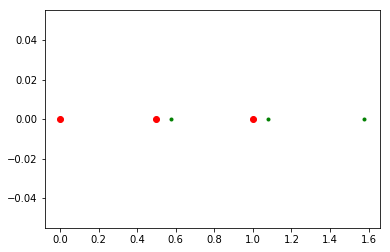

In [15]:
import matplotlib.pyplot as plt
EigenVectorNumber = 2
plt.plot([x1,x2,x3],[0,0,0],'ro')
plt.plot([x1+Eigenvectors[0,EigenVectorNumber],x2+Eigenvectors[1,EigenVectorNumber],x3+Eigenvectors[2,EigenVectorNumber]],[0,0,0],'g.')
plt.show()

In [20]:
mode = 0
V = Eigenvectors[:,mode]
L = EignenValues[mode]

print(0.5*np.dot(V,np.dot(StiffnessMatrixNPFLOAT,V)))
print(L)

168000000.00000012
336000000.0000001


# Strain Energy and Work - See PDF handwritten notes on ClickUP
## What is the strain energy for these displacements?
## Given tha 1000N force as applied and that the computed displacements were:
## $$\boldsymbol{q} = [0,\;\;2.381\times 10^{-5},\;\;1.190\times10^{-5}]$$
## What was the work done?

In [69]:
K = StiffnessMatrixNPFLOAT
q = np.array([0,2.381, 1.190])*1E-5
F = np.array([0,1000,0])
Work = 0.5*np.dot(q,F)
print("Work Done: {} J".format(Work))

Work Done: 0.011905 J


## What is the strain energy?

In [71]:
K = StiffnessMatrixNPFLOAT
q = np.array([0,2.381, 1.190])*1E-5
F = np.array([0,1000,0])
StrainEnergy = 0.5*np.dot(q,np.dot(K,q))
print("Work Done: {} J".format(StrainEnergy))

Work Done: 0.0119052409 J


## Numerically these values are same! [Note displacement only given with four significant figures - agreement within at least four significant figures]